In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import log_loss

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [13]:
df = pd.read_csv("../data/sleep.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")
y[y==5] = 4

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.1,test_size=0.1,stratify=y)

# model

In [7]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    tor = 256
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < tor,out=np.zeros(log_odds_1.shape)+tor)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < tor,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [8]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [9]:
learning_rate = 0.1
bins = 2
lam = 3
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 1
tolerance = 0.04


total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
eg.initialize_nodes(log_odds,p)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()
stack.extend(eg.nodes)
losses.extend(origin_losses)

for i in range(100):
    for j in range(6):
        eg.evolve(total_size,elite_size,log_odds=log_odds,p=p,tolerance=tolerance,verbose=0)
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes[num_features:],tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),sum([n.numNode for n in stack]),i)
    # if len(stack) > 8000:
    #         break


AttributeError: 'NoneType' object has no attribute 'metrics'

In [45]:
def training_data(node,y_train_one_hot,log_odds,p,test_log_odds=None,test_p=None):
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    if test_log_odds != None:
        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)

        return log_odds,p,test_log_odds,test_p
    
    return log_odds,p

def get_order(stack,y_train_one_hot,log_odds,p,previous_sse):
    score = []
    
    for node in stack:
        log_odds,p = training_data(node,y_train_one_hot,log_odds,p)
        
        sse = np.sum(np.power(y_train_one_hot - p,2))
        score.append(previous_sse - sse)
        previous_sse = sse
    
    return [stack[i] for i in np.argsort(score)[::-1]]

        

28842.77832049737 12511.619295898854 12511.619295898854


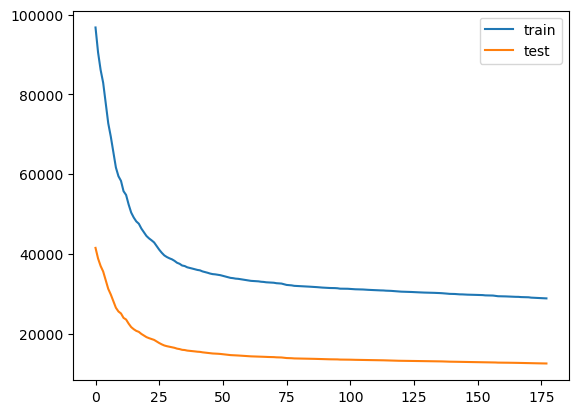

27414.31933816208 11993.618276993984 11993.618276993984


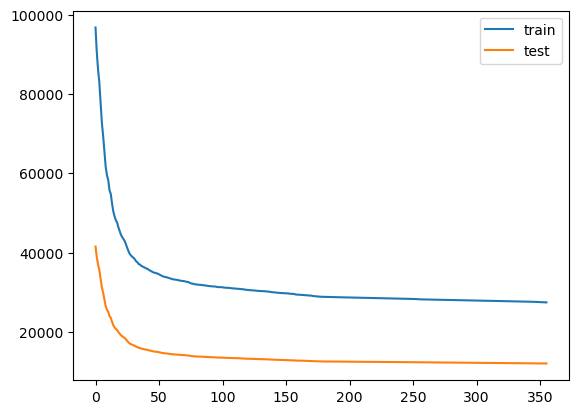

26699.43498004954 11757.648234739552 11757.648234739552


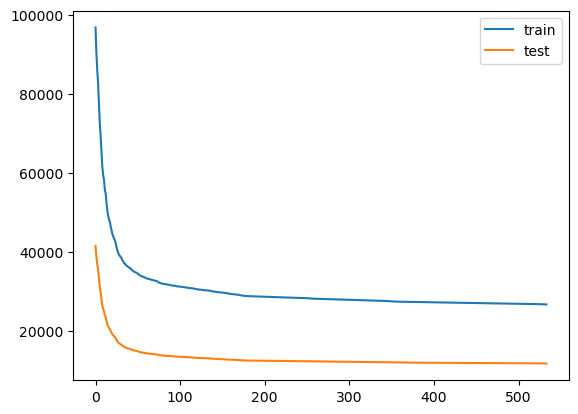

26244.446937583805 11622.77844699314 11622.77844699314


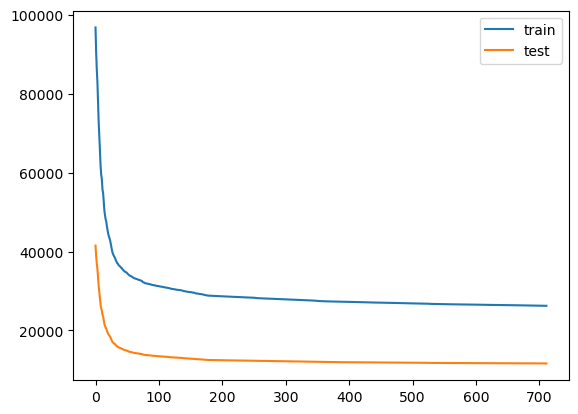

25913.902257987193 11534.002798833095 11534.002798833095


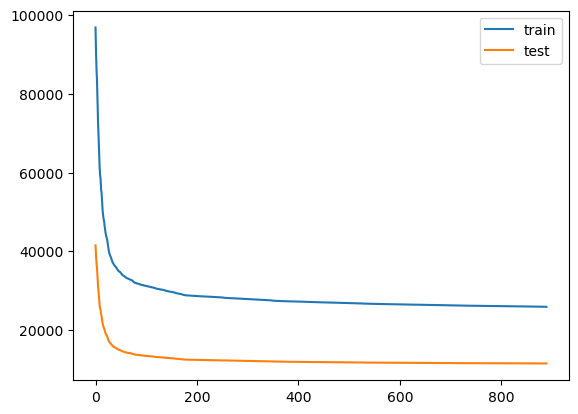

25654.90377062399 11472.096126057691 11472.096126057691


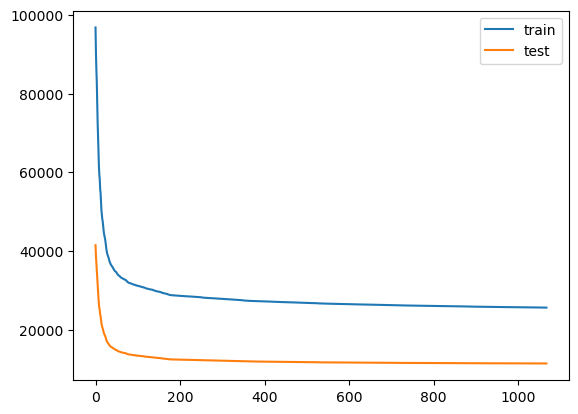

25441.04471472058 11425.958552547721 11425.958552547721


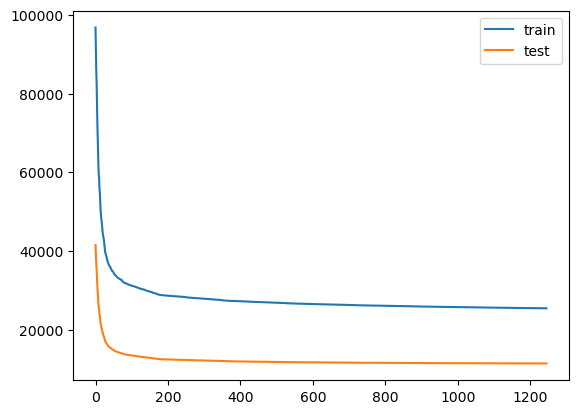

25259.497282843797 11390.826259523603 11390.826259523603


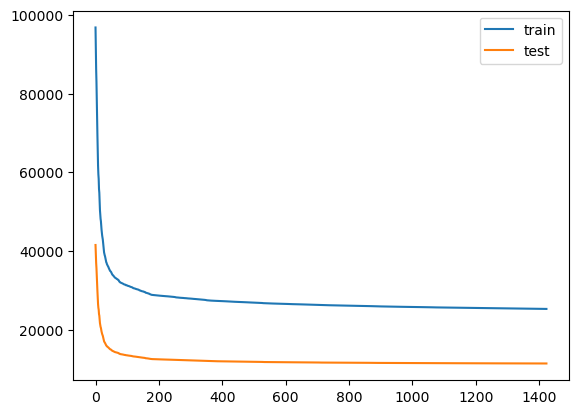

25100.866639682743 11363.246721730293 11363.246721730293


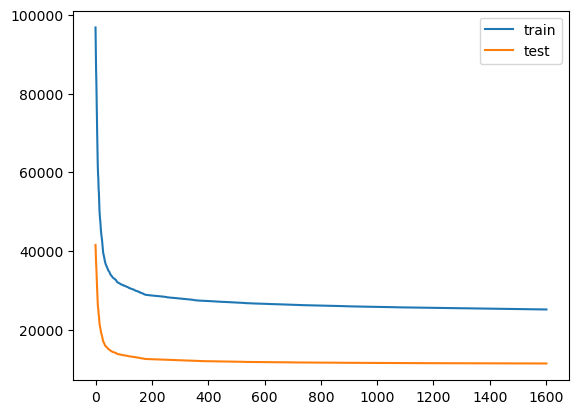

24960.23605370068 11341.297568962922 11341.297568962922


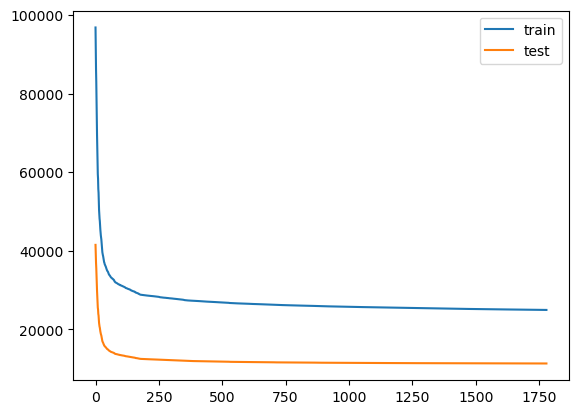

24833.054769602757 11323.856956224427 11323.856145962407


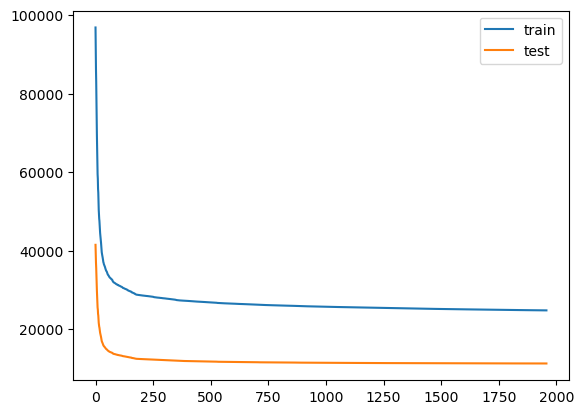

24717.415343518325 11308.972855817465 11308.972855817465


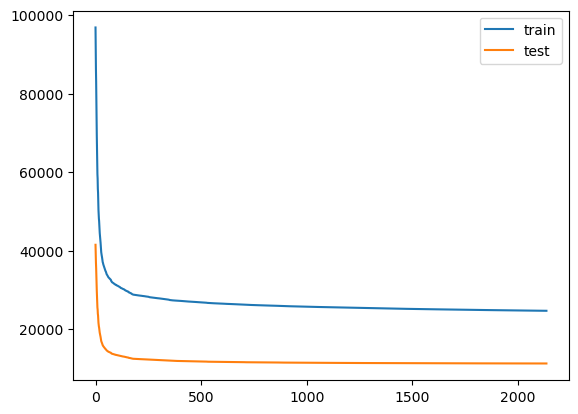

24610.714056746438 11296.361100595988 11296.361100595988


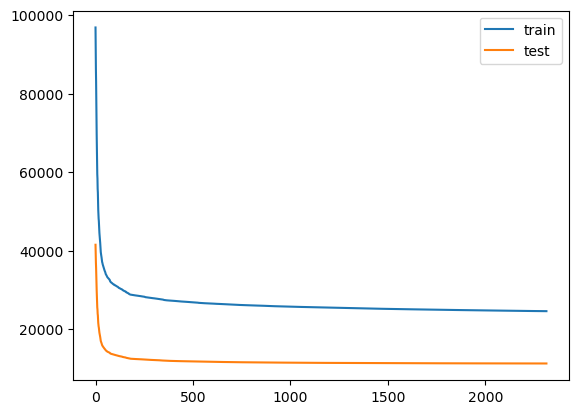

24511.618498299067 11286.279031177784 11286.279031177784


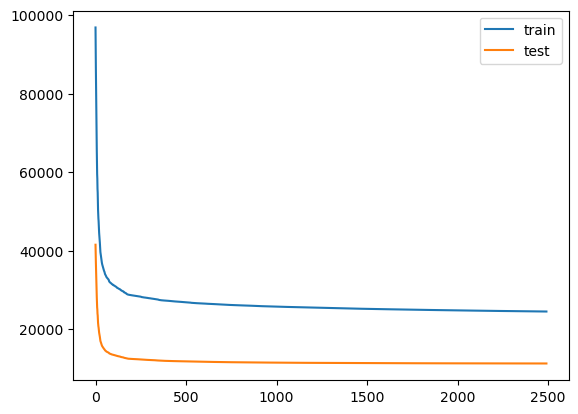

24419.95060028934 11277.899967946007 11277.889816681984


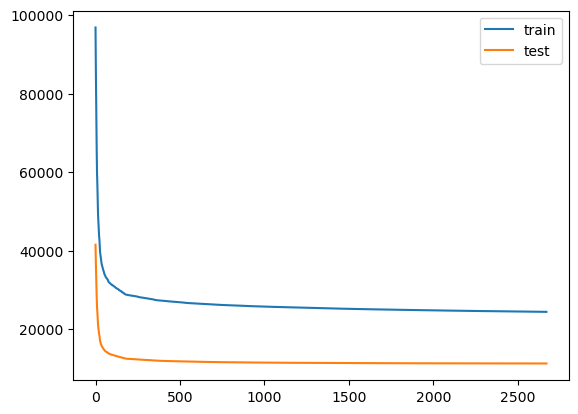

24333.859944978227 11270.818514913592 11270.818514913592


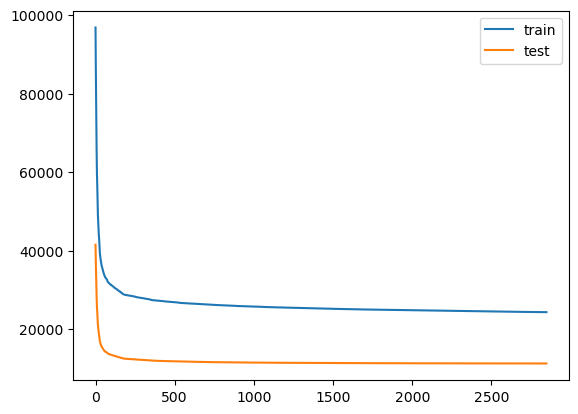

24252.6024099809 11264.819954959901 11264.819954959901


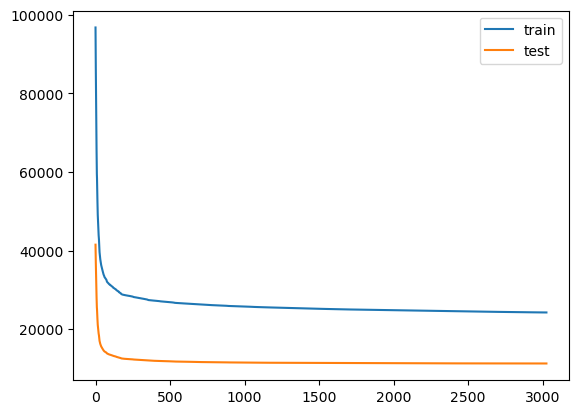

24175.816721888088 11260.178961480124 11260.178961480124


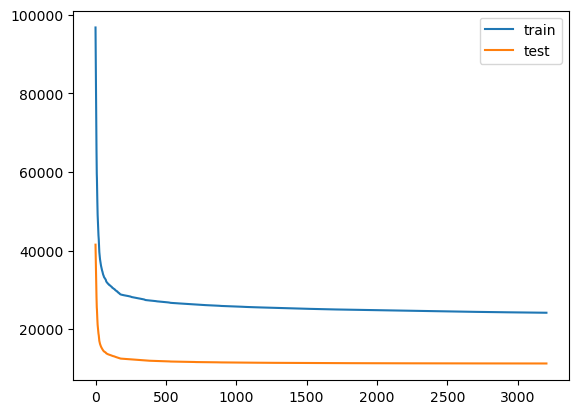

KeyboardInterrupt: 

In [46]:
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

# a = get_order(a,y_train_one_hot,log_odds,p,previous_sse=np.sum(np.power(y_train_one_hot - p,2)))

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []

for _ in range(100):
    score = []
    
    for i,node in enumerate(a):
        node.estimator.lam = 1 + 10 * node.numNode + 100 * node.depth
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


        train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
        # score.append(previous_sse - train_sse[-1])
        # previous_sse = train_sse[-1]


        # pred = np.argmax(p,axis=1)
        # train_acc.append(accuracy_score(pred,y_train))
        # test_pred = np.argmax(test_p,axis=1)
        # test_acc.append(accuracy_score(test_pred,y_test))
    
    # a = [a[i] for i in np.argsort(score)[::-1]]

    # plt.plot(train_acc)
    # plt.plot(test_acc)
    # print(train_acc[-1],test_acc[-1],max(test_acc))

    plt.plot(train_sse)
    plt.plot(test_sse)
    print(train_sse[-1],test_sse[-1],min(test_sse))

    plt.legend(["train","test"])
    plt.show()
    

In [42]:
sum([n.numNode for n in stack])

1588

              precision    recall  f1-score   support

           0    0.78079   0.82476   0.80217     14951
           1    0.56410   0.17706   0.26952      6337
           2    0.78649   0.90753   0.84269     36888
           3    0.81025   0.74228   0.77478      7582
           4    0.80547   0.65787   0.72423      8377

    accuracy                        0.78329     74135
   macro avg    0.74942   0.66190   0.68268     74135
weighted avg    0.77091   0.78329   0.76519     74135

              precision    recall  f1-score   support

           0    0.75321   0.79541   0.77374      6408
           1    0.37743   0.11455   0.17576      2715
           2    0.77124   0.88944   0.82613     15810
           3    0.76688   0.70246   0.73326      3250
           4    0.76750   0.63538   0.69521      3590

    accuracy                        0.75643     31773
   macro avg    0.68725   0.62745   0.64082     31773
weighted avg    0.73308   0.75643   0.73570     31773



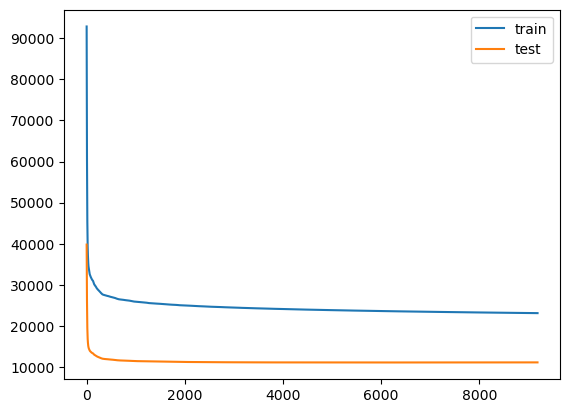

In [43]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

# Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2136
           1       1.00      1.00      1.00       905
           2       1.00      1.00      1.00      5269
           3       1.00      1.00      1.00      1083
           4       1.00      1.00      1.00      1197

    accuracy                           1.00     10590
   macro avg       1.00      1.00      1.00     10590
weighted avg       1.00      1.00      1.00     10590

              precision    recall  f1-score   support

           0       0.65      0.62      0.63      2136
           1       0.19      0.21      0.20       905
           2       0.73      0.73      0.73      5270
           3       0.62      0.62      0.62      1083
           4       0.56      0.58      0.57      1197

    accuracy                           0.63     10591
   macro avg       0.55      0.55      0.55     10591
weighted avg       0.64      0.63      0.63     10591



# XGBoost

In [35]:
import xgboost

In [36]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train,verbose=1)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    0.93200   0.93680   0.93439      2136
           1    0.94472   0.64199   0.76447       905
           2    0.90452   0.97628   0.93903      5269
           3    0.95057   0.92336   0.93677      1083
           4    0.95684   0.87051   0.91164      1197

    accuracy                        0.92238     10590
   macro avg    0.93773   0.86979   0.89726     10590
weighted avg    0.92412   0.92238   0.91985     10590

              precision    recall  f1-score   support

           0    0.74500   0.78511   0.76453      2136
           1    0.35775   0.14033   0.20159       905
           2    0.77787   0.87381   0.82306      5270
           3    0.74906   0.73315   0.74102      1083
           4    0.77214   0.64829   0.70481      1197

    accuracy                        0.75338     10591
   macro avg    0.68036   0.63614   0.64700     10591
weighted avg    0.73175   0.75338   0.73640     10591

train: 1424.9967946147

(500, 6.0, 38292)

# GDBT

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
# clf = GradientBoostingClassifier(n_estimators=100,validation_fraction=0.1,verbose=1)
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len([ est.tree_ for ests in clf.estimators_ for est in ests]),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

      Iter       Train Loss   Remaining Time 
         1           1.2380            4.24s
         2           1.1570            4.10s
         3           1.0945            4.37s
         4           1.0456            4.22s
         5           1.0047            4.12s
         6           0.9695            4.07s
         7           0.9396            4.00s
         8           0.9146            3.92s
         9           0.8916            3.84s
        10           0.8721            3.80s
        20           0.7613            3.32s
        30           0.7117            2.85s
        40           0.6832            2.40s
        50           0.6631            1.99s
        60           0.6474            1.58s
        70           0.6347            1.18s
        80           0.6246            0.79s
        90           0.6159            0.39s
       100           0.6081            0.00s
              precision    recall  f1-score   support

           0    0.75973   0.80384   0.78116 

(500, 7464)

# batch

In [43]:
# batch
train_acc = []
test_acc = []

train_sse = []
test_sse = []

train_log_loss = []
test_log_loss = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

learning_rate = 0.3
bins = 20
lam = 0
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 3

total_size = 100
elite_size = 3


stack = []

for _ in range(1000):
    eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
    eg.initialize_nodes(log_odds,p)
    origin_features = eg.nodes.copy()
    origin_losses = eg.losses.copy()

    # l = np.sort(origin_losses).astype(np.float64)
    # difference = l[1:] - l[:-1]
    # difference[difference==0] = 2**16
    # tolerance = min(difference) /10000

    tolerance = 0.01

    print("torlerance:",tolerance)

    batch = []
    loss = []
    for i in range(10):
        for j in range(10):
            eg.evolve(total_size,elite_size,log_odds,p,tolerance=tolerance,verbose=0)

        prev_len = len(batch)
        # winner = eg.nodes
        winner = eg.nodes[num_features:]
        for node in winner:
            node.estimator.get_metrics(node.val,y_train)
        batch,loss = eg.adding_unique_node(batch,loss,winner,tolerance=tolerance)
        hit_rate = (len(batch)-prev_len)/len(winner)
        # print("hit rate", hit_rate)

        eg.nodes = origin_features.copy()
        eg.losses = origin_losses.copy()
        # if len(stack) > 8000:
        #         break
        # if hit_rate < 0.001:
        #     break
    print(len(batch),sum([n.numNode for n in batch]),i)

    fits = [i.estimator.loss for i in batch]
    # a = [batch[i] for i in np.argsort(fits)]
    a = [batch[i] for i in np.argsort(fits)][::-1]

    for j in range(1):
        score = []
        
        for i,node in enumerate(a):
            node.estimator.lam = 1
            # node.estimator.lam = 1 + 30 * node.numNode + 1200 * node.depth
            grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
            log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

            test_grads = node.predict_grad(X_test)
            test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)

            pred = np.argmax(p,axis=1)
            train_acc.append(accuracy_score(pred,y_train))
            test_pred = np.argmax(test_p,axis=1)
            test_acc.append(accuracy_score(test_pred,y_test))

            # train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
            # test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))

            train_log_loss.append(log_loss(y_train_one_hot,p))
            test_log_loss.append(log_loss(y_test,test_p))


        # plt.plot(train_acc)
        # plt.plot(test_acc)
            
        print(train_acc[-1],test_acc[-1],max(test_acc))
        # print(train_sse[-1],test_sse[-1],min(test_sse))
        print(train_log_loss[-1],test_log_loss[-1],min(test_log_loss))
        
    stack.extend(batch)
    losses.extend(loss)

    # plt.plot(train_acc)
    # plt.plot(test_acc)

    # plt.plot(train_sse)
    # plt.plot(test_sse)
        
plt.plot(train_log_loss)
plt.plot(test_log_loss)

plt.legend(["train","test"])
plt.show()

# print("Node:",sum([n.numNode for n in stack]),"train acc:",train_acc[-1],"test acc:",train_acc[-1])
# print("Node:",sum([n.numNode for n in stack]),"train sse:",train_sse[-1],"test sse:",test_sse[-1])
print("Node:",sum([n.numNode for n in stack]),"train log_loss:",train_log_loss[-1],"test log_loss:",test_log_loss[-1])
    
    

torlerance: 0.01
198 3028 9
0.7379603399433428 0.7208006798224907 0.721178358984043
0.7129489985940443 0.7820981774265326 0.7819755544330432
torlerance: 0.01
185 3069 9
0.7676109537299339 0.7357190067038051 0.7364743650269097
0.6129742152275226 0.7271820674575816 0.7271493803964696
torlerance: 0.01
135 2067 9
0.7748819641170916 0.7378906618827307 0.7386460202058351
0.5884632507448744 0.7251992429305101 0.7234839887755151
torlerance: 0.01
128 1858 9
0.7818696883852692 0.7363799452365216 0.7390236993673874
0.5631542129795972 0.7236445074598895 0.721370458075775
torlerance: 0.01


KeyboardInterrupt: 

In [41]:
pred = np.argmax(p,axis=1)
test_pred = np.argmax(test_p,axis=1)

print("Acc:\n",accuracy_score(pred,y_train),"\n",accuracy_score(test_pred,y_test))


print("SSE:\n",np.sum(np.power(y_train_one_hot - p,2)),"\n",np.sum(np.power(y_test_one_hot - test_p,2)))


print("Log loss:\n",log_loss(y_train_one_hot,p),"\n",log_loss(y_test,test_p))

print(classification_report(y_train,pred,digits=5))
print(classification_report(y_test,test_pred,digits=5))

Acc:
 0.7628895184135978 
 0.7399678972712681
SSE:
 3577.3453332519703 
 3932.1404249039906
Log loss:
 0.6203357825097033 
 0.708702233004542
              precision    recall  f1-score   support

           0    0.72435   0.82303   0.77055      2136
           1    0.58015   0.08398   0.14672       905
           2    0.77358   0.89486   0.82981      5269
           3    0.78416   0.73130   0.75681      1083
           4    0.79612   0.61654   0.69492      1197

    accuracy                        0.76289     10590
   macro avg    0.73167   0.62994   0.63976     10590
weighted avg    0.75075   0.76289   0.73677     10590

              precision    recall  f1-score   support

           0    0.71612   0.78418   0.74860      2136
           1    0.38235   0.04309   0.07746       905
           2    0.75437   0.88520   0.81456      5270
           3    0.73892   0.70822   0.72324      1083
           4    0.74461   0.57728   0.65035      1197

    accuracy                        0.73997

In [42]:
test_acc[6000]

0.7502596544235672

In [43]:
sum([n.numNode for n in stack[:6000]])

41948